In [ ]:
#import necessary libraries

import torch
import numpy as np
import pandas
from torch.utils import data
import matplotlib.pyplot as plt
 
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.nn import Module
import torch.nn.functional as F
import math

 
from torch import nn

In [2]:
# Some libraries for a data to load from
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

transform = transforms.Compose([ # Transoforms the data to Tensor
    transforms.ToTensor()
])

# Load MNIST Dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # Train = True means Training Set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Train = False means Test Set
print(len(mnist_trainset)) # Size of mnist trainset is 60000
print(len(mnist_testset)) # Size of mnist testset is 10000

# Assigning Some Values Beforehand

batch_size = 100
n_iters = 3000
input_dim = 784
output_dim = 10
lr_rate = 0.1

# Construct minibatches from train_dataloaders and test_dataloader = [ (x1,y1), (x2,y2), ... ] 
# (xi,yi) are minibatch pairs of size 100 samples each
# Each sample in a minibatch pair (xi,yi) is of size 784 and 1 for x and y
from torch.utils.data import DataLoader, Subset
train_dataloaders = DataLoader(mnist_trainset, # MNIST trainset
                                batch_size=batch_size, # 100 batches
                                shuffle=True, # Shuffle the batches
                                drop_last=False # Dont drop the last batch
                     )

print(len(train_dataloaders)) # Length will be 600 because there are 600 batches

test_dataloader  = DataLoader(mnist_testset, # MNIST testset
                              batch_size=batch_size, # 100 batches
                              shuffle=False)

print(len(test_dataloader)) # Length will be 100 because there are 100 batches

dataiter = iter(train_dataloaders) # iterating the trainset batches
(train_features, train_labels) = next(dataiter) # Take the first minibatch
print(train_features.shape) # features of one minibatch will have the 4D size of [100, 1, 28, 28]

print(train_labels.shape) # # labels of one minibatch will have the size of [100]

60000
10000
600
100
torch.Size([100, 1, 28, 28])
torch.Size([100])


In [64]:
device = "cpu" # Couldn't install CUDA so it uses CPU
zdim = 100
fixed_noise = torch.randn(100, zdim, 1, 1, device=device) # Defining a fixed noise to use everywhere

class g_net(nn.Module): # THE GENERATOR Network
    def __init__(self):
        super(g_net, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100,out_channels=50,kernel_size=4,stride=1,bias=False), # Instead of using Fully Connected Layer in the
            nn.BatchNorm2d(50),                                                                     #beginning, it uses another deconvolution layer that
            nn.ReLU(),                                                            #basically does the same thing as Dense layer dimensionwise(Unflattened)

            nn.ConvTranspose2d(in_channels=50,out_channels=20,kernel_size=2,stride=2,bias=False),# Single output size 8 x 8 (8=(4-1)*2+(2-1)*1+1-2*0)
            nn.BatchNorm2d(20),                                                     #Yi = (Xi - 1)*stride[i] + ((Wi-1)*dilation[i] + 1) - 2*padding[i]
            nn.ReLU(),                                                              # Number of input channels 50
                                                                                    # Number of output channels 20 

            nn.ConvTranspose2d(in_channels=20,out_channels=20,kernel_size=5,stride=1,bias=False), # Single output size 12 x 12 (12=(8-1)*1+(5-1)*1+1-2*0)
            nn.BatchNorm2d(20),                                                        # Number of input channels 20
            nn.ReLU(),                                                                  # Number of output channels 20 

            nn.ConvTranspose2d(in_channels=20,out_channels=20,kernel_size=2,stride=2,bias=False),# Single output size 24 x 24 (24=(12-1)*2+(2-1)*1+1-2*0)
            nn.BatchNorm2d(20),                                                        # Number of input channels 20
            nn.ReLU(),                                                                  # Number of output channels 20 

            nn.ConvTranspose2d(in_channels=20,out_channels=1,kernel_size=5,stride=1,bias=True),# Single output size 28 x 28 (28=(24-1)*1+(5-1)*1+1-2*0)
            nn.Tanh()                                                                       # Number of input channels 20
        )                                                                                   # Number of output channels 1
    
    def forward(self, x):
        x = self.deconv(x)
        return x


In [65]:
generator = g_net()
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
generator(fixed_noise).shape

In [77]:
class d_lenet(nn.Module):# THE DISCRIMINATOR LENET
    def __init__(self):
        super(d_lenet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5,stride=2,bias=True),# 5x5 conv. kernel, single input channel, 20 output channels
            nn.LeakyReLU(negative_slope=0.2),                                       # single output is 12x12 : (28-(2+2))/2 = 12
                                                                                   # These do not have pooling, stride=2 does the work

            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5,stride=2,bias=False),# 5x5 conv. kernel, 20 input channels, 50 output channels
            nn.BatchNorm2d(50),                                                         # single output is 4x4 : (12-(2+2))/2) = 4
            nn.LeakyReLU(negative_slope=0.2),                                           # These do not have pooling, stride=2 does the work

            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=4,stride=1,bias=False),#basically does the same thing as Dense layer dimensionwise(Unflattened)
            nn.Sigmoid()                                                                # output dim is 1                     
        )
    
    def forward(self,x):
        x = self.conv(x)
        x = x.reshape((100,1))
        return x

In [78]:
distributor = d_lenet()
optimizerD = torch.optim.Adam(distributor.parameters(), lr=0.0002, betas=(0.5,0.999))
distributor(generator(fixed_noise)).shape

In [92]:
bce = nn.BCELoss()

def g_loss(G,D,noise):
    deceiving_labels = torch.ones((noise.shape[1],1))

    scores = D(G(noise))
    
    loss = bce(scores, deceiving_labels)
    loss.backward()
    return loss

In [94]:
def d_loss(D,G,real_images, noise):
    fake_images = G(noise)
    fake_labels= torch.zeros((noise.shape[1],1))
    
    real_labels = torch.ones((real_images.shape[0],1))

    xx = torch.stack(real_images,fake_images,dim=0)
    yy = torch.stack(real_labels, fake_labels, dim=0)

    scores = D(xx)

    loss = bce(scores, yy)
    loss.backward()
    return loss

In [95]:
def d_loss2(D,images,labels):
    scores = D(images)
    
    labels = labels.reshape((100,1))
    
    loss = bce(scores,labels)
    loss.backward()
    return loss

In [105]:
# TRAIN
d_loss_values = []
g_loss_values = []
img_list = []

for epoch in range(5):
    lossD = 0
    lossG = 0
    batchnum = 0
    print("For Epoch:", epoch)
    for x,y in train_dataloaders:

        # Train the discriminator
        optimizerD.zero_grad()

        real_cpu = x.to(device)
        fake = generator(fixed_noise)

        real_label = torch.ones((100,1))
        fake_label = torch.zeros((100,1))

        lossD_real = d_loss2(distributor,real_cpu,real_label) #Real samples are input to discriminator

        lossD_fake = d_loss2(distributor,fake,fake_label) #Fake samples are input to discriminator

        lossD += (lossD_real+lossD_fake)/2 # Dloss in total

        optimizerD.step()

        # Train the generator
        optimizerG.zero_grad()
        lossG = g_loss(generator,distributor,fixed_noise)
        optimizerG.step()

        batchnum += 1
        if batchnum%100 == 0:
            if batchnum == 600:
                print("Average D_loss value:", lossD/batchnum)
                print("Average G_loss value:", lossG/batchnum)
            else:
                print("Average D_loss_value at batch number", batchnum,":",lossD/batchnum)
                print("Average G_loss_value at batch number", batchnum,":",lossG/batchnum)
            d_loss_values.append(lossD/batchnum) # snapshots of loss values for each 100 batches
            g_loss_values.append(lossG/batchnum)

    img_list.append(torchvision.utils.make_grid(fake, normalize=True)) #saving the fake images to compare later

For Epoch: 0
Average D_loss_value at batch number 100 : tensor(0.4387, grad_fn=<DivBackward0>)
Average G_loss_value at batch number 100 : tensor(0.0146, grad_fn=<DivBackward0>)
Average D_loss_value at batch number 200 : tensor(0.4430, grad_fn=<DivBackward0>)
Average G_loss_value at batch number 200 : tensor(0.0066, grad_fn=<DivBackward0>)
Average D_loss_value at batch number 300 : tensor(0.4437, grad_fn=<DivBackward0>)
Average G_loss_value at batch number 300 : tensor(0.0036, grad_fn=<DivBackward0>)
Average D_loss_value at batch number 400 : tensor(0.4443, grad_fn=<DivBackward0>)
Average G_loss_value at batch number 400 : tensor(0.0031, grad_fn=<DivBackward0>)
Average D_loss_value at batch number 500 : tensor(0.4461, grad_fn=<DivBackward0>)
Average G_loss_value at batch number 500 : tensor(0.0022, grad_fn=<DivBackward0>)
Average D_loss value: tensor(0.4463, grad_fn=<DivBackward0>)
Average G_loss value: tensor(0.0018, grad_fn=<DivBackward0>)
For Epoch: 1
Average D_loss_value at batch nu

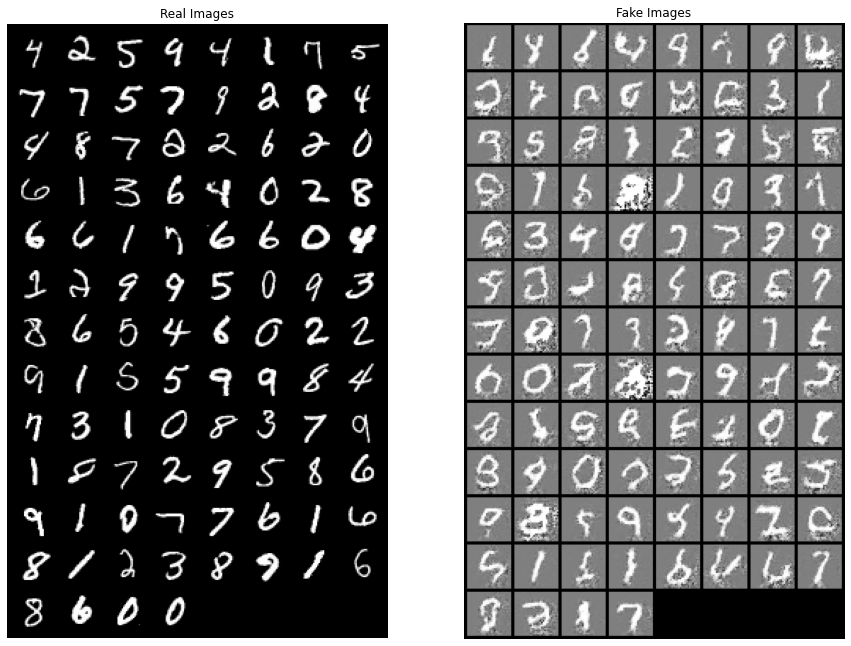

In [106]:
real_batch = next(iter(train_dataloaders))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:100], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

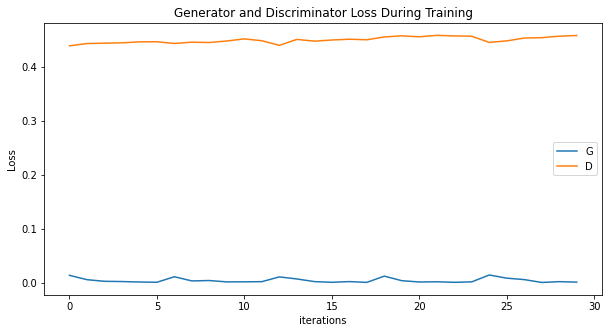

In [107]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Tensor(g_loss_values),label="G")
plt.plot(Tensor(d_loss_values),label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()